In [1]:
%%capture
# Install required packages
!pip install anndata
!pip install hdf5plugin
!pip install scikit-misc
!pip install umap-learn
!pip install umap.plot
!pip install scanpy

In [43]:
# Import required packages
import os
import h5py
import hdf5plugin
import umap
import itertools
import math

import pandas as pd
import anndata as ad
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib

from google.colab import drive
from scipy.sparse import csc_matrix
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from scipy.special import betainc

In [3]:
style.use('seaborn-whitegrid')

<ipython-input-3-0429e6a128c0>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-whitegrid')


In [4]:
# Mount drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
# Declare useful constants
DATA_DIR = '/content/drive/MyDrive/Thesis/dance/dance/data/'
PRED_DIR = '/content/drive/MyDrive/Thesis/dance/dance/data/predictions'
IMAGE_DIR = '/content/drive/MyDrive/Thesis/Images'
MOUSE_ANNOT = 'mouse_liver_cite_fltr_rna'
INPUT_SUBTASK_NAME = 'openproblems_competition_cite_mixed_rna'
SUBTASKS = ['mouse_liver_cite_fltr_rna',
            'openproblems_competition_cite_fltr_prep_rna',
            'openproblems_competition_cite_fltr_prep_altstrat_rna',
            'mouse_liver_cite_fltr_denoised_rna',
            'mouse_liver_cite_fltr_denoised_pretrain_rna']
MODELS = ['dengkw', 'rf', 'BABEL', 'GCN']
PREDICTIONS = itertools.product(MODELS, SUBTASKS)

In [6]:
# For most part taken from stackoverflow to return both coeffs and p vals
# https://stackoverflow.com/questions/24432101/correlation-coefficients-and-p-values-for-all-pairs-of-rows-of-a-matrix

def corrcoef(matrix, rowvar=False):
    r = np.corrcoef(matrix, rowvar=rowvar)
    rf = r[np.triu_indices(r.shape[0], 1)]
    df = matrix.shape[1] - 2
    ts = rf * rf * (df / (1 - rf * rf))
    pf = betainc(0.5 * df, 0.5, df / (df + ts))
    p = np.zeros(shape=r.shape)
    p[np.triu_indices(p.shape[0], 1)] = pf
    p[np.tril_indices(p.shape[0], -1)] = p.T[np.tril_indices(p.shape[0], -1)]
    p[np.diag_indices(p.shape[0])] = np.ones(p.shape[0])
    return r, p

In [7]:
# Exploratory analysis of datasets
input_mouse_annot = pd.read_csv(os.path.join(DATA_DIR, 'citeseq_mouse_annot.csv'))

In [8]:
mouse_annot = input_mouse_annot.iloc[:,:2].reset_index()
mouse_annot.columns = input_mouse_annot.columns[:4]

In [9]:
# Read h5ad files containing raw ADT counts
human_train_mod2 = ad.read_h5ad(os.path.join(DATA_DIR, 
                                             INPUT_SUBTASK_NAME, 
                                             f'{INPUT_SUBTASK_NAME}.censor_dataset.output_train_mod2.h5ad'))

human_test_mod2 = ad.read_h5ad(os.path.join(DATA_DIR, 
                                            INPUT_SUBTASK_NAME, 
                                            f'{INPUT_SUBTASK_NAME}.censor_dataset.output_test_mod2.h5ad'))

In [10]:
# Read h5ad files containing raw ADT counts
mouse_train_mod2 = ad.read_h5ad(os.path.join(DATA_DIR, 
                                             MOUSE_ANNOT, 
                                             f'{MOUSE_ANNOT}.censor_dataset.output_train_mod2.h5ad'))

mouse_test_mod2 = ad.read_h5ad(os.path.join(DATA_DIR, 
                                            MOUSE_ANNOT, 
                                            f'{MOUSE_ANNOT}.censor_dataset.output_test_mod2.h5ad'))

In [11]:
human_protein = ad.concat([human_train_mod2, human_test_mod2])
mouse_protein = ad.concat([mouse_train_mod2, mouse_test_mod2])

In [12]:
human_annot = human_protein.obs
mouse_annot = mouse_protein.obs

In [13]:
mouse_cell_types = mouse_annot.groupby('cluster').count().iloc[:,1]
human_cell_types = human_annot.groupby('cell_type').count().iloc[:,1]

In [54]:

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)


<ipython-input-41-2f8706a323ee>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(human_cells, rotation=45)
<ipython-input-41-2f8706a323ee>:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(mouse_cells, rotation=45)


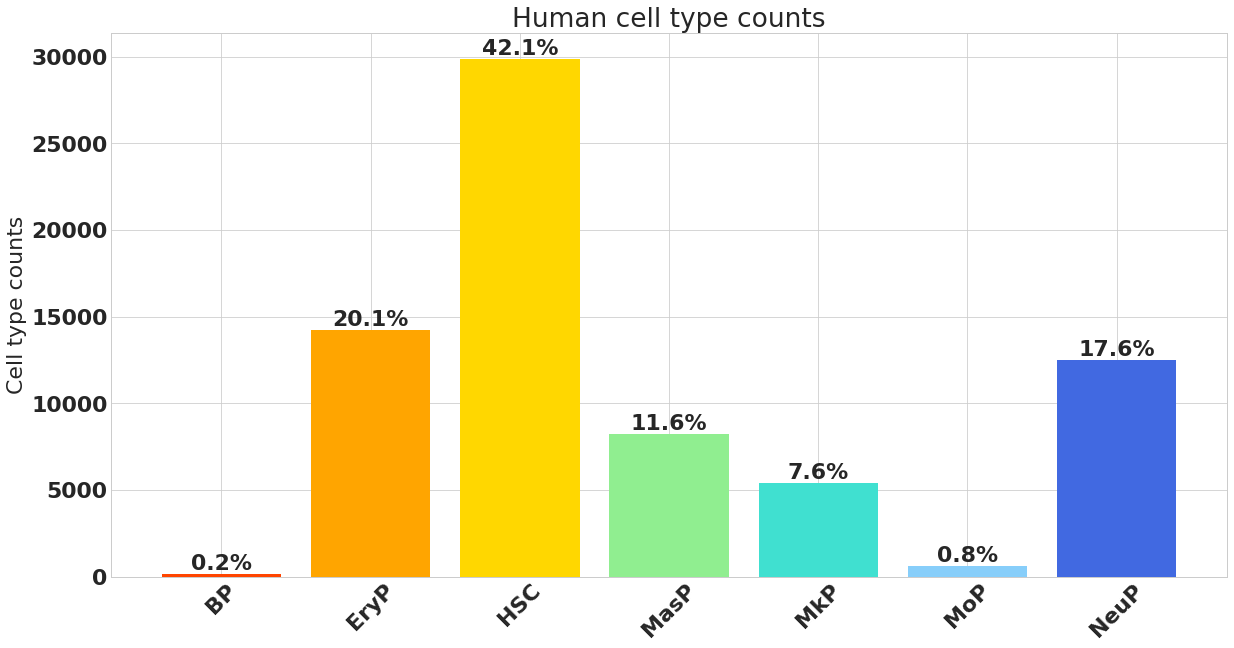

In [41]:
fig, ax1 = plt.subplots(1, 1, figsize=(20, 10))
human_cells = human_cell_types.index.values
mouse_cells = mouse_cell_types.index.values

human_counts = human_cell_types.values
mouse_counts = mouse_cell_types.values

human_counts_pct = np.round(human_counts / human_counts.sum() * 100, 1)
human_counts_pct = human_counts_pct.astype('str')

colors = ['orangered', 
          'orange', 
          'gold',  
          'lightgreen',
          'turquoise',
          'lightskyblue',
          'royalblue']

ax1.bar(human_cells, human_counts, label=human_cells, color=colors)
ax1.set_title('Human cell type counts')
ax1.set_ylabel('Cell type counts')
ax1.set_xticklabels(human_cells, rotation=45)

for rect, label in zip(ax1.patches, human_counts_pct):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 5, label + '%', ha="center", va="bottom")

"""
scatter_color_dict = dict(zip(human_cells, colors))
scatter_colors = pd.Series(human_annot['cell_type'].map(scatter_color_dict))
ax2.scatter(embedding[:, 0], embedding[:, 1], c=scatter_colors)
"""

ax2.bar(mouse_cells, mouse_counts, label=mouse_cells, color=colors)
ax2.set_title('Mouse cell type counts')
ax2.set_ylabel('Cell type counts')
ax2.set_xticklabels(mouse_cells, rotation=45)

plt.savefig(f"{IMAGE_DIR}/cell_types.png")

In [ ]:
umap.plot.points(embedding)

AttributeError: ignored

In [ ]:
true_dict = {}
for model, subtask in PREDICTIONS:
  task_path = os.path.join(DATA_DIR, 
                           subtask, 
                           f'{subtask}.censor_dataset.output_test_mod2.h5ad')
  true_dict[subtask] = ad.read_h5ad(task_path)

In [ ]:
pred_dict = {}
for pred_name in os.listdir(PRED_DIR):
  pred_dict[pred_name] = np.load(os.path.join(PRED_DIR, pred_name))

In [50]:
metrics = ['rmse', 'rmse_std', 'pearsonr', 'pearsonr_std']
zeros = np.zeros((len(MODELS), len(SUBTASKS) * len(metrics)))
eval_df = pd.DataFrame(zeros, 
                       index=MODELS, 
                       columns=pd.MultiIndex.from_product([SUBTASKS, metrics]))

corr_dict = {}

for subtask in SUBTASKS:

  task_path = os.path.join(DATA_DIR, 
                           subtask, 
                           f'{subtask}.censor_dataset.output_test_mod2.h5ad')
  task_anndata = ad.read_h5ad(task_path)
  task_prot_names = task_anndata.var_names
  true_labels = task_anndata.X.toarray()

  for model in MODELS:

    pred_path = os.path.join(PRED_DIR, model + '_' + subtask + '.npy')
    assert(os.path.exists(pred_path))
    preds = np.load(pred_path)

    print(preds.shape, true_labels.shape)
    rmse = mean_squared_error(preds, true_labels, multioutput='raw_values', squared=False)
    rmse_std_dev = np.std(rmse)
    avg_rmse = mean_squared_error(preds, true_labels, multioutput='uniform_average', squared=False)

    # pearson_r, pearson_p = corrcoef(np.concatenate((preds, true_labels), axis=1))
    corr_list = []
    idx_list = []
    for i in range(preds.shape[1]):
      r, p = pearsonr(preds[:, i], true_labels[:, i])
      if p < 0.05:
        corr_list.append(r)
        idx_list.append(i)

    corr_list = np.round(np.array(corr_list), 2)
    corr_dict[(model, subtask)] = np.array([corr_list, idx_list])

    sorted_corrs = sorted(zip(corr_list, idx_list), key=lambda x: x[0])
    print(sorted_corrs[-5:])
    print(sorted_corrs[:5])
    top5_idx = [x[1] for x in sorted_corrs[-5:]]
    print(task_prot_names[top5_idx])
    print(rmse)

    eval_df.loc[model, (subtask, 'rmse')] = np.round(avg_rmse, 3)
    eval_df.loc[model, (subtask, 'rmse_std')] = np.round(rmse_std_dev, 3)
    eval_df.loc[model, (subtask, 'pearsonr')] = np.round(np.average(corr_list), 2)
    eval_df.loc[model, (subtask, 'pearsonr_std')] = np.round(np.std(corr_list), 2)

    

eval_df

(2456, 174) (2456, 174)
[(0.9, 74), (0.9, 126), (0.91, 8), (0.91, 91), (0.93, 36)]
[(0.05, 128), (0.05, 154), (0.07, 67), (0.07, 117), (0.07, 134)]
Index(['CD357', 'IA-IE', 'CD11b', 'CD5', 'CD2'], dtype='object', name='Unnamed: 0')
[3.9210325e-01 3.6401737e-01 2.9887387e-01 4.6630761e-01 4.4589433e-01
 3.9890733e-01 3.7739590e-01 3.1266579e-01 3.5291645e-01 4.1028294e-01
 2.0693754e-01 3.2918030e-01 2.1011509e-01 2.0984171e-01 1.3712196e-01
 2.1821852e-01 1.9581930e-01 1.6578777e-01 4.1612294e-01 1.0681244e-01
 7.6359212e-02 4.5023620e-01 1.8829668e-01 4.3919837e-01 2.2551991e-01
 3.4980673e-01 3.3263302e-01 1.3606907e-01 1.4098760e-01 3.5331616e-01
 1.6670778e-01 2.0392528e-01 2.7412912e-01 1.7742935e-01 1.7805435e-01
 3.4049416e-01 3.8451579e-01 1.5711205e-01 3.2440254e-01 3.1712008e-01
 2.3179127e-01 2.7320805e-01 1.9382294e-01 3.1327388e-01 2.2465090e-01
 1.7045085e-01 3.7948769e-01 3.1001455e-01 3.1060830e-01 7.0159733e-02
 4.6964166e-01 3.8902119e-01 3.3854496e-01 3.4434202e-01 2

/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


(7099, 140) (7099, 140)
[(0.88, 113), (0.89, 138), (0.9, 43), (0.91, 89), (0.91, 108)]
[(0.15, 53), (0.16, 101), (0.2, 19), (0.22, 26), (0.24, 22)]
Index(['CD36', 'CD88', 'CD32', 'CD41', 'CD71'], dtype='object')
[0.37341306 0.3099165  0.23505656 0.22124936 0.18710095 0.23578623
 0.33391252 0.31704897 0.21154103 0.31361058 0.35884124 0.32954392
 0.33373216 0.3664491  0.27848554 0.33554265 0.25901684 0.3041195
 0.32249558 0.34364387 0.19802217 0.24432279 0.3523949  0.36813152
 0.23247951 0.35708714 0.36040938 0.3681727  0.24989581 0.23510626
 0.27705893 0.324608   0.33225372 0.33836246 0.36112988 0.29955825
 0.27934626 0.23743221 0.27367514 0.37051794 0.31357157 0.34989128
 0.3125528  0.3585147  0.3704181  0.27780563 0.35148618 0.35199597
 0.29071704 0.30639648 0.22920784 0.28061956 0.3778108  0.32333282
 0.26045775 0.19911218 0.30063844 0.25151205 0.3627616  0.3618271
 0.3528808  0.21933731 0.24451074 0.259091   0.37613437 0.34338528
 0.32307756 0.28379712 0.21474557 0.37780762 0.228364

/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


(2456, 174) (2456, 174)
[(0.11, 158), (0.12, 98), (0.13, 75), (0.14, 54), (0.26, 147)]
[(-0.05, 108), (-0.04, 165), (0.04, 47), (0.04, 72), (0.04, 114)]
Index(['PIRA-PIRB', 'CD64', 'CD36', 'CD270', 'Ly6C'], dtype='object', name='Unnamed: 0')
[5.15807271e-01 5.85570276e-01 3.32493901e-01 5.51028430e-01
 5.46157897e-01 4.28467035e-01 6.00277483e-01 4.89453614e-01
 8.29935670e-01 9.22581136e-01 2.12471887e-01 3.65964621e-01
 2.20307767e-01 2.41853461e-01 1.38716966e-01 2.42158264e-01
 2.02869847e-01 1.71813741e-01 6.56838536e-01 1.06999129e-01
 7.70846307e-02 7.53185451e-01 1.91145658e-01 5.99259853e-01
 2.29209334e-01 5.08550584e-01 6.06875360e-01 1.37684911e-01
 1.41395345e-01 5.96915722e-01 1.69717744e-01 2.10311532e-01
 3.07834089e-01 1.80531517e-01 1.83297038e-01 3.90145093e-01
 1.04520953e+00 1.59988388e-01 3.85193229e-01 3.80167037e-01
 4.94047105e-01 3.03036749e-01 2.09424362e-01 4.00790572e-01
 2.31063619e-01 2.38138840e-01 5.00336289e-01 3.47313821e-01
 3.83897245e-01 7.26027861

/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlat

[(0.12, 98), (0.12, 158), (0.14, 54), (0.14, 75), (0.27, 147)]
[(-0.05, 108), (-0.05, 165), (0.04, 5), (0.04, 65), (0.04, 72)]
Index(['CD64', 'PIRA-PIRB', 'CD270', 'CD36', 'Ly6C'], dtype='object', name='Unnamed: 0')
[5.14917970e-01 5.84359944e-01 3.32276404e-01 5.49624860e-01
 5.44883609e-01 4.28114235e-01 5.99371552e-01 4.88484889e-01
 8.29162836e-01 9.21427250e-01 2.12389603e-01 3.65271449e-01
 2.20170051e-01 2.41724625e-01 1.38729051e-01 2.42161855e-01
 2.02836514e-01 1.71783596e-01 6.55227482e-01 1.06950492e-01
 7.70841092e-02 7.51358211e-01 1.91048011e-01 5.98711431e-01
 2.29089096e-01 5.07438123e-01 6.06098294e-01 1.37686744e-01
 1.41373187e-01 5.95916808e-01 1.69627443e-01 2.10260093e-01
 3.07468504e-01 1.80444434e-01 1.83238328e-01 3.89240265e-01
 1.04304755e+00 1.59961000e-01 3.84405792e-01 3.79464924e-01
 4.92773026e-01 3.02770913e-01 2.09307879e-01 3.99662048e-01
 2.30959982e-01 2.37716511e-01 4.99609739e-01 3.46636772e-01
 3.83271903e-01 7.25793466e-02 6.92865372e-01 5.9035

/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


mouse_liver_cite_fltr_rna                                 \
                            rmse rmse_std pearsonr pearsonr_std   
dengkw                     0.280    0.123     0.50         0.27   
rf                         0.474    0.333     0.01         0.05   
BABEL                      0.301    0.138     0.61         0.19   
GCN                        0.292    0.136     0.47         0.26   

       openproblems_competition_cite_fltr_prep_rna                    \
                                              rmse rmse_std pearsonr   
dengkw                                       0.306    0.057     0.51   
rf                                           0.424    0.157    -0.02   
BABEL                                        0.313    0.058     0.49   
GCN                                          0.316    0.059     0.47   

                    openproblems_competition_cite_fltr_prep_altstrat_rna  \
       pearsonr_std                                                 rmse   
dengkw         0.17                                              0.337     
rf             0.02                                              0.355     
BABEL          0.17                                              0.347     
GCN            0.17                                              0.357     

                                      mouse_liver_cite_fltr_denoised_rna  \
       rmse_std pearsonr pearsonr_std                               rmse   
dengkw    0.084     0.35         0.16                              0.395   
rf        0.090     0.25         0.17                              0.398   
BABEL     0.107     0.33         0.15                              0.403   
GCN       0.106     0.28         0.13                              0.396   

                                       \
       rmse_std pearsonr pearsonr_std   
dengkw    0.249     0.07         0.04   
rf        0.249     0.06         0.04   
BABEL     0.254     0.08         0.04   
GCN       0.249    -0.02         0.04   

       mouse_liver_cite_fltr_denoised_pretrain_rna                    \
                                              rmse rmse_std pearsonr   
dengkw                                       0.394    0.248     0.07   
rf                                           0.398    0.249     0.06   
BABEL                                        0.402    0.252     0.06   
GCN                                          0.395    0.249    -0.04   

                     
       pearsonr_std  
dengkw         0.05  
rf             0.05  
BABEL          0.03  
GCN            0.01

In [53]:
for model, subtask in itertools.product(MODELS, SUBTASKS): 
  print(corr_dict[(model, subtask)], subtask, model)

[array([0.64, 0.78, 0.44, 0.53, 0.57, 0.37, 0.78, 0.77, 0.91, 0.9 , 0.22,
        0.43, 0.3 , 0.5 , 0.16, 0.43, 0.27, 0.3 , 0.77, 0.09, 0.13, 0.8 ,
        0.17, 0.68, 0.17, 0.72, 0.84, 0.15, 0.08, 0.81, 0.18, 0.25, 0.45,
        0.18, 0.24, 0.48, 0.93, 0.19, 0.54, 0.55, 0.88, 0.43, 0.39, 0.62,
        0.23, 0.7 , 0.65, 0.45, 0.58, 0.26, 0.73, 0.75, 0.76, 0.72, 0.87,
        0.73, 0.84, 0.88, 0.39, 0.23, 0.74, 0.48, 0.51, 0.41, 0.54, 0.69,
        0.42, 0.07, 0.74, 0.27, 0.76, 0.78, 0.19, 0.31, 0.9 , 0.58, 0.53,
        0.17, 0.86, 0.72, 0.85, 0.88, 0.69, 0.84, 0.57, 0.8 , 0.4 , 0.85,
        0.54, 0.8 , 0.91, 0.79, 0.74, 0.16, 0.76, 0.32, 0.78, 0.58, 0.31,
        0.56, 0.54, 0.77, 0.36, 0.76, 0.22, 0.77, 0.85, 0.87, 0.8 , 0.85,
        0.26, 0.45, 0.2 , 0.68, 0.27, 0.2 , 0.07, 0.2 , 0.65, 0.16, 0.75,
        0.73, 0.66, 0.15, 0.9 , 0.73, 0.05, 0.1 , 0.23, 0.33, 0.1 , 0.12,
        0.07, 0.11, 0.16, 0.62, 0.78, 0.15, 0.45, 0.13, 0.52, 0.6 , 0.29,
        0.82, 0.83, 0.6 , 0.82, 0.13, 

In [47]:
from matplotlib import rcParams, rcParamsDefault
rcParams.update(rcParamsDefault)

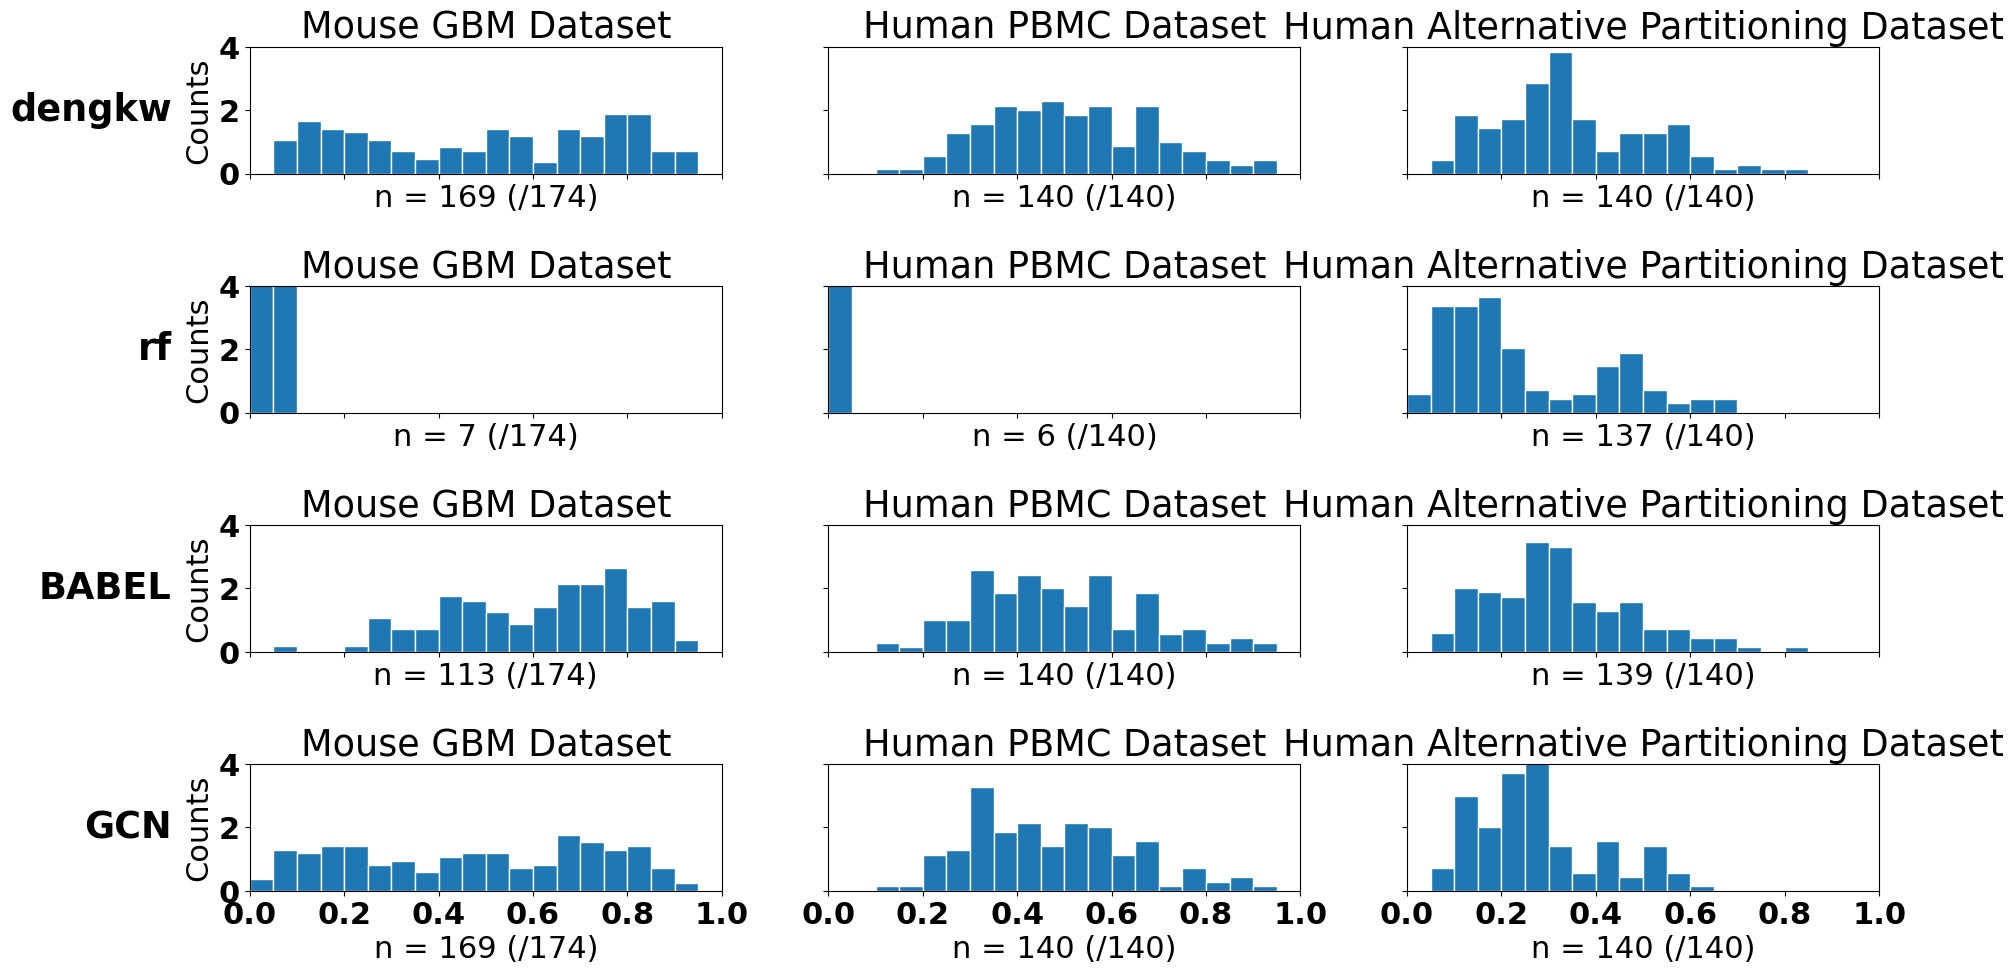

In [55]:
fig, axes = plt.subplots(4, 
                         3, 
                         figsize=(20, 10), 
                         sharey='all',
                         sharex='all')

x_pos = np.arange(10)
bins = np.arange(0, 1.1, 0.05)
pad = 5
titles = ['Mouse GBM Dataset', 'Human PBMC Dataset', 'Human Alternative Partitioning Dataset']

for model, rows in zip(MODELS, axes):
  i = 0
  for subtask, ax in zip(SUBTASKS, rows):
    ax.hist(corr_dict[(model, subtask)][0, :], 
            density=True, 
            bins=bins,
            edgecolor='white')
    if i == 0:
      ax.set_ylabel('Counts')
    ax.set_title(titles[i])
    max_prot_count = 174 if 'mouse' in subtask else 140
    ax.set_xlabel(f'n = {len(corr_dict[(model, subtask)][0, :])} (/{max_prot_count})')
    ax.set_ylim([0, 4])
    ax.set_xlim([0, 1])
    i += 1

'''
for ax, task in zip(axes[0, :], SUBTASKS):
    ax.annotate(task, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline', weight='bold')
'''

for ax, model in zip(axes[:, 0], MODELS):
    ax.annotate(model, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', weight='bold')

fig.tight_layout()
# tight_layout doesn't take these labels into account. We'll need 
# to make some room. These numbers are are manually tweaked. 
# You could automatically calculate them, but it's a pain.
fig.subplots_adjust(left=0.15, top=0.95)

plt.savefig(f"{IMAGE_DIR}/correlations.png")

In [ ]:
for model, axes in zip(MODELS, axes):
  for subtask, ax in zip(SUBTASKS, axes):
    corr_dict[(model, subtask)][0, :]

TypeError: ignored

In [ ]:
bins = np.arange(0, 1.1, 0.1)

In [ ]:
bins

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])